In [1]:
%matplotlib notebook
import control as c
import ipywidgets as w
import numpy as np

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
import matplotlib.animation as animation

display(HTML('<script> $(document).ready(function() { $("div.input").hide(); }); </script>'))

## Design di un sistema di controllo per un pendolo inverso su un carrello

Il seguente esempio riguarda la progettazione del controllo per un pendolo inverso su di un carrello. La struttura è costituita da un pendolo inverso incernierato ad un carrello che può muoversi liberamente in una vasca contenente dell'olio (quest'ultimo funge da ammortizzatore).
<br><br>
<img src="Images/pend.png" width="40%" />
<br>

Il modello è non lineare e ha due gradi di libertà. Per controllarlo con un unico controllore PID, bisogna linearizzarlo attorno alla posizione di equilibrio e non considerare il movimento lineare del carrello per il posizionamento. Pertanto i risultati sono validi solo per movimenti angolari molto piccoli e il carrello risulta libero di muoversi incotrollatamente.

Le equazioni del moto linearizzate sono:
<br>
$$(J+mL^2)\cdot\ddot{\varphi}-mgL\cdot\varphi=mL\cdot\ddot{x}$$
$$(M+m)\cdot\ddot{x}+b\cdot x-mL\cdot\ddot{\varphi}=F$$
<br>
Dove:
<br>
$$J=\frac{1}{12}m(2L)^2$$
<br>
La funzione di trasferimento può essere espressa come:
<br>
$$G(s)=\frac{\frac{mL}{q}s^2}{s^4+\frac{b(J+mL^2)}{q}s^3-\frac{(M+m)mgL}{q}s^2-\frac{bmgL}{q}s}$$
<br>
Dove:
<br>
$$q=(M+m)(J+mL^2)-(mL)^2$$
<br>

Il tuo compito è quello di progettare un controller che garantisca prestazioni accettabili!

<b>Per prima cosa, scegli un modello del sistema!</b><br>
Alterna tra i diversi modelli con valori preselezionati casualmente (pulsanti *Modello 1* - *Modello 6*). Facendo clic sul pulsante *Preset*, vengono impostati parametri di controllo validi che non possono essere ulteriormente modificati.

<IPython.core.display.Javascript object>


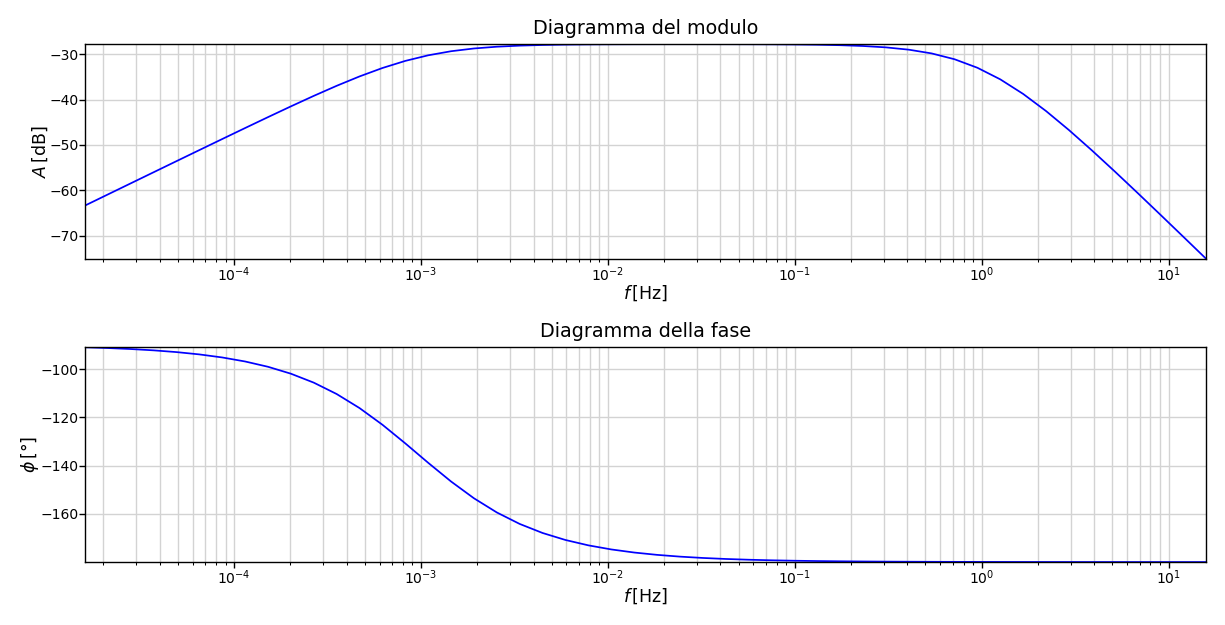

ToggleButtons(description='Sistema: ', index=6, layout=Layout(width='60%'), options=(('Modello 1', 0), ('Model…

Output()

Output()

In [2]:
# System parameters

g = 9.81   # m/s^2 - gravitational acceleration

# Figure definition

fig1, ((f1_ax1), (f1_ax2)) = plt.subplots(2, 1)
fig1.set_size_inches((9.8, 5))
fig1.set_tight_layout(True)

f1_line1, = f1_ax1.plot([], [])
f1_line2, = f1_ax2.plot([], [])  

f1_ax1.grid(which='both', axis='both', color='lightgray')
f1_ax2.grid(which='both', axis='both', color='lightgray')

f1_ax1.autoscale(enable=True, axis='both', tight=True)
f1_ax2.autoscale(enable=True, axis='both', tight=True)

f1_ax1.set_title('Diagramma del modulo', fontsize=11)
f1_ax1.set_xscale('log')
f1_ax1.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax1.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=10)
f1_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

f1_ax2.set_title('Diagramma della fase', fontsize=11)
f1_ax2.set_xscale('log')
f1_ax2.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax2.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=10)
f1_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)

def build_base_model(M, m, L, b):
   
    J=1/3*m*L*L
    C=(M+m)*(J+m*L*L)-(m*m*L*L)
    W_sys = c.tf([m*L/C, 0, 0], [1, b*(J+m*L*L)/C,-(M+m)*m*g*L/C, -b*m*g*L/C, 0])
    
    print('Funzione di trasferimento del sistema:')
    print(W_sys)
    
    # System analysis
    
    poles = c.pole(W_sys)     # Poles
    
    print('Poli del sistema:\n')
    print(poles)
    
    global f1_line1, f1_line2
    
    f1_ax1.lines.remove(f1_line1)
    f1_ax2.lines.remove(f1_line2)
    
    mag, phase, omega = c.bode_plot(W_sys, Plot=False)   # Bode-plot
    
    f1_line1, = f1_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f1_line2, = f1_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')   
    
    f1_ax1.relim()
    f1_ax2.relim()
    f1_ax1.autoscale_view()
    f1_ax2.autoscale_view()
    
# GUI widgets

typeSelect = w.ToggleButtons(
    options=[('Modello 1', 0), ('Modello 2', 1), ('Modello 3', 2), ('Modello 4', 3), ('Modello 5', 4), ('Modello 6', 5), ('Preset', -1)],
    value=-1, description='Sistema: ', layout=w.Layout(width='60%'))

M_slider = w.FloatLogSlider(value=2, base=10, min=-1, max=2, description='M [kg] :', continuous_update=False,
                            layout=w.Layout(width='auto', flex='5 5 auto'))
m_slider = w.FloatLogSlider(value=0.1, base=10, min=-1, max=2, description='m [kg] :', continuous_update=False,
                            layout=w.Layout(width='auto', flex='5 5 auto'))
L_slider = w.FloatLogSlider(value=0.125, base=10, min=-2, max=1, description='L [m] :', continuous_update=False,
                            layout=w.Layout(width='auto', flex='5 5 auto'))
b_slider = w.FloatLogSlider(value=0.002, base=10, min=-3, max=1, description='b [Ns/m] :', continuous_update=False,
                            layout=w.Layout(width='auto', flex='5 5 auto'))

input_data = w.interactive_output(build_base_model, {'M':M_slider, 'm':m_slider, 'L':L_slider, 'b':b_slider})

def update_sliders(index):
    global M_slider, m_slider, L_slider, b_slider
    
    Mval = [0.5, 0.5, 1, 1, 5, 10, 2]
    mval = [0.1, 0.5, 0.5, 0.5, 1, 3, 0.5]
    Lval = [0.1, 0.2, 0.1, 0.5, 0.5, 1, 0.2]
    bval = [0.015, 0.015, 0.03, 0.1, 0.5, 0.5, 0.015]
    
    M_slider.value = Mval[index]
    m_slider.value = mval[index]
    L_slider.value = Lval[index]
    b_slider.value = bval[index]
    
    if index == -1:
        M_slider.disabled = True
        m_slider.disabled = True
        L_slider.disabled = True
        b_slider.disabled = True
    else:
        M_slider.disabled = False
        m_slider.disabled = False
        L_slider.disabled = False
        b_slider.disabled = False
    
input_data2 = w.interactive_output(update_sliders, {'index':typeSelect})

display(typeSelect, input_data2)
display(w.HBox([w.VBox([M_slider, m_slider], layout=w.Layout(width='45%')),
                w.VBox([L_slider, b_slider], layout=w.Layout(width='45%'))]), input_data)

Il sistema contiene un palo instabile che deve essere contrastato adeguatamente, altrimenti il pendolo non può essere bilanciato.<br>
<b>Seleziona una configurazione appropriata per il controller! Qual è la migliore per il sistema scelto? Perché?<br>
Imposta il tuo controller in modo che raggiunga l'allineamento verticale con un overshoot minimo! </b>

È possibile attivare / disattivare ciascuno dei componenti I e D. Se D è attivo, è possibile applicare anche il filtro del primo ordine, regolato dalla costante di tempo di derivazione.

<IPython.core.display.Javascript object>


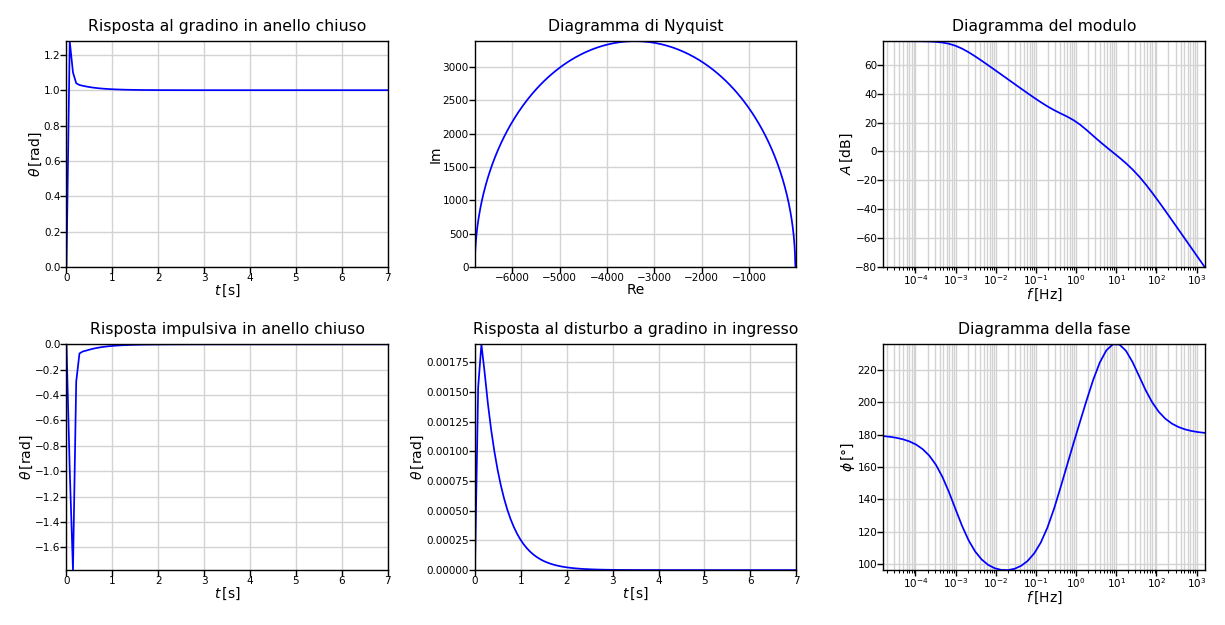

Output()

In [3]:
# PID balancer

fig2, ((f2_ax1, f2_ax2, f2_ax3), (f2_ax4, f2_ax5, f2_ax6)) = plt.subplots(2, 3)
fig2.set_size_inches((9.8, 5))
fig2.set_tight_layout(True)

f2_line1, = f2_ax1.plot([], [])
f2_line2, = f2_ax2.plot([], []) 
f2_line3, = f2_ax3.plot([], [])
f2_line4, = f2_ax4.plot([], [])  
f2_line5, = f2_ax5.plot([], [])
f2_line6, = f2_ax6.plot([], [])

f2_ax1.grid(which='both', axis='both', color='lightgray')
f2_ax2.grid(which='both', axis='both', color='lightgray')
f2_ax3.grid(which='both', axis='both', color='lightgray')
f2_ax4.grid(which='both', axis='both', color='lightgray')
f2_ax5.grid(which='both', axis='both', color='lightgray')
f2_ax6.grid(which='both', axis='both', color='lightgray')

f2_ax1.autoscale(enable=True, axis='both', tight=True)
f2_ax2.autoscale(enable=True, axis='both', tight=True)
f2_ax3.autoscale(enable=True, axis='both', tight=True)
f2_ax4.autoscale(enable=True, axis='both', tight=True)
f2_ax5.autoscale(enable=True, axis='both', tight=True)
f2_ax6.autoscale(enable=True, axis='both', tight=True)


f2_ax1.set_title('Risposta al gradino in anello chiuso', fontsize=9)
f2_ax1.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax1.set_ylabel(r'$\theta\/$[rad]', labelpad=0, fontsize=8)
f2_ax1.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax2.set_title('Diagramma di Nyquist', fontsize=9)
f2_ax2.set_xlabel(r'Re', labelpad=0, fontsize=8)
f2_ax2.set_ylabel(r'Im', labelpad=0, fontsize=8)
f2_ax2.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax3.set_title('Diagramma del modulo', fontsize=9)
f2_ax3.set_xscale('log')
f2_ax3.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=8)
f2_ax3.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=8)
f2_ax3.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax4.set_title('Risposta impulsiva in anello chiuso', fontsize=9)
f2_ax4.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax4.set_ylabel(r'$\theta\/$[rad]', labelpad=0, fontsize=8)
f2_ax4.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax5.set_title('Risposta al disturbo a gradino in ingresso', fontsize=9)
f2_ax5.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax5.set_ylabel(r'$\theta\/$[rad]', labelpad=0, fontsize=8)
f2_ax5.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax6.set_title('Diagramma della fase', fontsize=9)
f2_ax6.set_xscale('log')
f2_ax6.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=8)
f2_ax6.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=8)
f2_ax6.tick_params(axis='both', which='both', pad=0, labelsize=6)

def position_control(Kp, Ti, Td, Fd, Ti0, Td0, Fd0, M, m, L, b):
    
    J=1/3*m*L*L
    C=(M+m)*(J+m*L*L)-(m*m*L*L)
    W_sys = c.tf([m*L/C, 0, 0], [1, b*(J+m*L*L)/C,-(M+m)*m*g*L/C, -b*m*g*L/C, 0])
    
    # PID Controller
    
    P = Kp             # Proportional term
    I = Kp / Ti        # Integral term
    D = Kp * Td        # Derivative term
    Td_f = Td / Fd     # Derivative term filter
    
    W_PID = c.parallel(c.tf([P], [1]),
                       c.tf([I * Ti0], [1 * Ti0, 1 * (not Ti0)]),
                       c.tf([D * Td0, 0], [Td_f * Td0 * Fd0, 1]))  # PID controller in time constant format
    
    W_open = c.series(W_PID, W_sys)         # Open loop 
    W_closed = c.feedback(W_open, 1, -1)    # Closed loop with negative feedback
    
    W_load = c.feedback(W_sys, W_PID, -1)   # Transfer function of the disturbance based errors  
                        
    # Display

    global f2_line1, f2_line2, f2_line3, f2_line4, f2_line5, f2_line6
    
    f2_ax1.lines.remove(f2_line1)
    f2_ax2.lines.remove(f2_line2)
    f2_ax3.lines.remove(f2_line3)
    f2_ax4.lines.remove(f2_line4)
    f2_ax5.lines.remove(f2_line5)
    f2_ax6.lines.remove(f2_line6)
    
    tout, yout = c.step_response(W_closed)
    f2_line1, = f2_ax1.plot(tout, yout, lw=1, color='blue') 
    
    _, _, ob = c.nyquist_plot(W_open, Plot=False)   # Small resolution plot to determine bounds        
    real, imag, freq = c.nyquist_plot(W_open, omega=np.logspace(np.log10(ob[0]), np.log10(ob[-1]), 1000), Plot=False)
    f2_line2, = f2_ax2.plot(real, imag, lw=1, color='blue')
    
    mag, phase, omega = c.bode_plot(W_open, Plot=False)
    f2_line3, = f2_ax3.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f2_line6, = f2_ax6.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')
    
    tout, yout = c.impulse_response(W_closed)
    f2_line4, = f2_ax4.plot(tout, yout, lw=1, color='blue')   
    
    tout, yout = c.step_response(W_load)
    f2_line5, = f2_ax5.plot(tout, yout, lw=1, color='blue') 
    
    f2_ax1.relim()
    f2_ax2.relim()
    f2_ax3.relim()
    f2_ax4.relim()
    f2_ax5.relim()
    f2_ax6.relim()
    f2_ax1.autoscale_view()
    f2_ax2.autoscale_view()
    f2_ax3.autoscale_view()
    f2_ax4.autoscale_view()
    f2_ax5.autoscale_view()
    f2_ax6.autoscale_view()
    
def update_controller(index):
    global Kp_slider, Ti_slider, Td_slider, Fd_slider, Ti_button, Td_button
    
    if index == -1:
        Kp_slider.value = 500
        Ti_slider.value = 0.5
        Td_slider.value = 0.05
        Fd_slider.value = 10
        Ti_button.value = True
        Td_button.value = True
        Fd_button.value = True
        
        Kp_slider.disabled = True
        Ti_slider.disabled = True
        Td_slider.disabled = True
        Fd_slider.disabled = True
        Ti_button.disabled = True
        Td_button.disabled = True
        Fd_button.disabled = True
    else:
        Kp_slider.disabled = False
        Ti_slider.disabled = False
        Td_slider.disabled = False
        Fd_slider.disabled = False
        Ti_button.disabled = False
        Td_button.disabled = False
        Fd_button.disabled = False

# GUI widgets

Kp_slider = w.FloatLogSlider(value=500, base=10, min=-3, max=5, description='Kp:', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))
Ti_slider = w.FloatLogSlider(value=0.0125, base=10, min=-4, max=1, description='', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))
Td_slider = w.FloatLogSlider(value=0.16, base=10, min=-4, max=1, description='', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))
Fd_slider = w.FloatLogSlider(value=1, base=10, min=0, max=3, description='', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))

Ti_button = w.ToggleButton(value=True, description='Ti',
                           layout=w.Layout(width='auto', flex='1 1 0%'))
Td_button = w.ToggleButton(value=True, description='Td',
                           layout=w.Layout(width='auto', flex='1 1 0%'))
Fd_button = w.ToggleButton(value=False, description='Fd',
                           layout=w.Layout(width='auto', flex='1 1 0%'))

input_data = w.interactive_output(position_control, {'Kp': Kp_slider, 'Ti': Ti_slider, 'Td': Td_slider,
                                                     'Fd': Fd_slider, 'Ti0' : Ti_button, 'Td0': Td_button,
                                                     'Fd0': Fd_button, 'M':M_slider, 'm':m_slider,
                                                     'L':L_slider, 'b':b_slider})

w.interactive_output(update_controller, {'index':typeSelect})

display(w.HBox([Kp_slider, Ti_button, Ti_slider, Td_button, Td_slider, Fd_button, Fd_slider]), input_data)

Nella seguente simulazione è possibile osservare il movimento del sistema in base al controller sviluppato. Puoi applicare qualche disturbo e vedere come reagisce il sistema.

<b>Il controller può realmente bilanciare il pendolo? Per quanto tempo? L'input e il movimento del carrello sono realistici?</b>
<br><br>
<i>(Data la scalatura automatica del grafico, le soluzioni instabili potrebbero apparire nulle fino a poco prima dell'ultimo istante rappresentato.)</i>

<IPython.core.display.Javascript object>


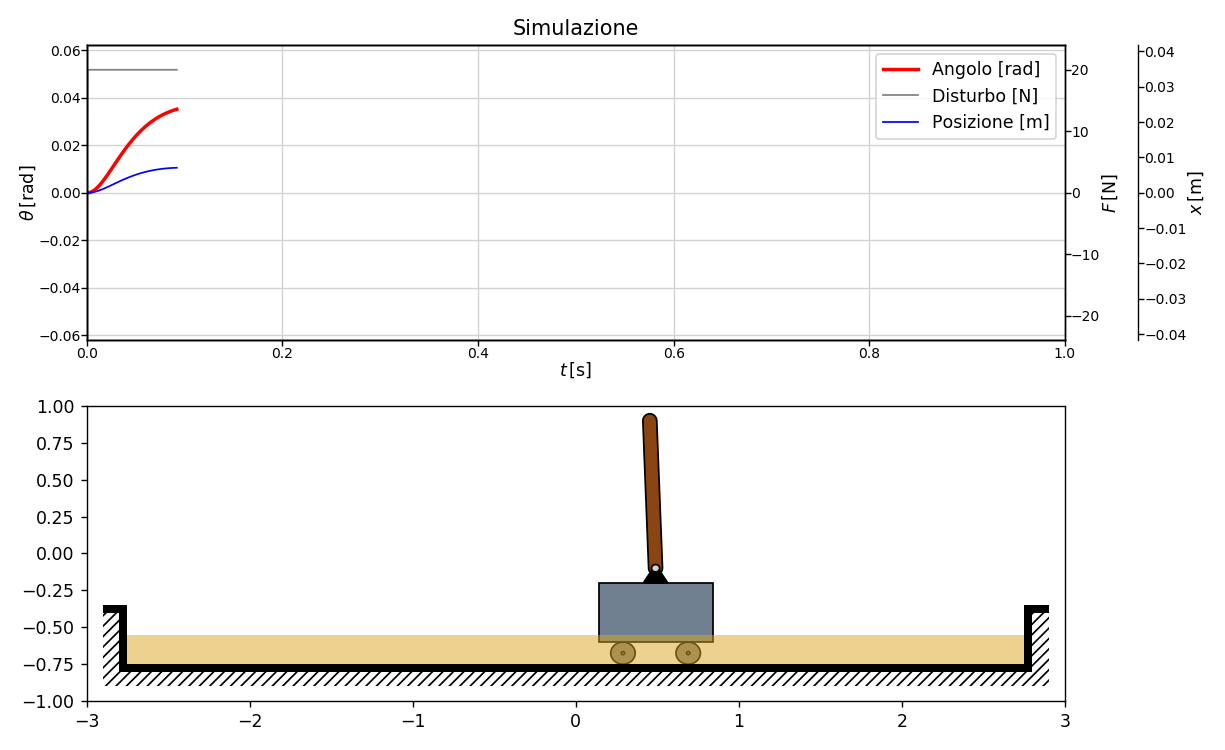

Output()

In [4]:
# Simulation

anim_fig = plt.figure()
anim_fig.set_size_inches((9.8, 6))
anim_fig.set_tight_layout(True)

anim_ax1 = anim_fig.add_subplot(211)
anim_ax2 = anim_ax1.twinx()
anim_ax3 = anim_ax1.twinx()

frame_count=1000

l1 = anim_ax1.plot([], [], lw=2, color='red')
l2 = anim_ax2.plot([], [], lw=1, color='grey')
l3 = anim_ax3.plot([], [], lw=1, color='blue')

line1 = l1[0]
line2 = l2[0]
line3 = l3[0]

anim_ax1.legend(l1+l2+l3, ['Angolo [rad]', 'Disturbo [N]', 'Posizione [m]'], loc=1)

anim_ax1.set_title('Simulazione', fontsize=12)
anim_ax1.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=10)
anim_ax1.set_ylabel(r'$\theta\/$[rad]', labelpad=0, fontsize=10)
anim_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)
anim_ax2.set_ylabel(r'$F\/$[N]', labelpad=0, fontsize=10)
anim_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)
anim_ax3.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=10)
anim_ax3.tick_params(axis='both', which='both', pad=0, labelsize=8)

anim_ax1.grid(which='both', axis='both', color='lightgray')

anim_ax3.spines["right"].set_position(("axes", 1.075))

T_plot = []
R_plot = []
F_plot = []
X_plot = []

# Scene data

scene_ax = anim_fig.add_subplot(212)
scene_ax.set_xlim((-3, 3))
scene_ax.set_ylim((-1, 1))
#scene_ax.axis('off')


scene_ax.add_patch(patches.Rectangle((-2.9, -0.9), 5.8, 0.5, fill=False, ec='black', lw=0, hatch='////', zorder=0))
scene_ax.add_patch(patches.Rectangle((-2.8, -0.8), 5.6, 0.4, fill=True, fc='black', lw=0, zorder=5))
scene_ax.add_patch(patches.Rectangle((-2.9, -0.4), 5.8, 0.05, fill=True, fc='black', lw=0, zorder=5))
scene_ax.add_patch(patches.Rectangle((-2.75, -0.75), 5.5, 0.5, fill=True, fc='white', lw=0, zorder=10))

scene_ax.add_patch(patches.Rectangle((-2.75, -0.75), 5.5, 0.2, fill=True, fc='goldenrod', alpha=0.5, lw=0, zorder=30))

wheel_1 = patches.Circle((-0.2, -0.675), radius=0.075, fill=True, ec='black', fc='gray', lw=1, zorder=15)
wheel_2 = patches.Circle((0.2, -0.675), radius=0.075, fill=True, ec='black', fc='gray', lw=1, zorder=15)
wheel_1_p = patches.Circle((-0.2, -0.675), radius=0.01, fill=True, ec='black', fc='lightgray', lw=1, zorder=25)
wheel_2_p = patches.Circle((0.2, -0.675), radius=0.01, fill=True, ec='black', fc='lightgray', lw=1, zorder=25)
cart = patches.Rectangle((-0.35, -0.6), 0.7, 0.4, fill=True, ec='black', fc='slategray', lw=1, zorder=25)
joint = patches.Polygon(np.stack(([-0.075, 0.075, 0, -0.075], [-0.2, -0.2, -0.075, -0.2])).T,
                        fill=True, lw=1, ec='black', fc='black', zorder=40)
joint_p = patches.Circle((0, -0.1), radius=0.025, fill=True, ec='black', fc='lightgray', lw=1, zorder=45)

scene_ax.add_patch(wheel_1)
scene_ax.add_patch(wheel_2)
scene_ax.add_patch(wheel_1_p)
scene_ax.add_patch(wheel_2_p)
scene_ax.add_patch(cart)
scene_ax.add_patch(joint)
scene_ax.add_patch(joint_p)

tilt_transform = transforms.Affine2D()

rod_outline, = scene_ax.plot([0, 0], [-0.1, 0.9], color='black', solid_capstyle='round', lw=9, zorder=30,
                             transform=tilt_transform  + scene_ax.transData)
rod, = scene_ax.plot([0, 0], [-0.1, 0.9], color='saddlebrown', solid_capstyle='round', lw=7, zorder=35,
                     transform=tilt_transform  + scene_ax.transData)

cart_pos = []


def simulation(Kp, Ti, Td, Fd, Ti0, Td0, Fd0, M, m, L, b, T, dt, F, Ff, Fa, Fo):
    
    # Controller
    P = Kp                      # Proportional term
    I = Kp / Ti                 # Integral term
    D = Kp * Td                 # Derivative term
    Td_f = Td / Fd              # Derivative term filter
    
    W_PID = c.parallel(c.tf([P], [1]),
                       c.tf([I * Ti0], [1 * Ti0, 1 * (not Ti0)]),
                       c.tf([D * Td0, 0], [Td_f * Td0 * Fd0, 1]))  # PID controller
    
    # System model    
    
    J=1/12*m*L*L
    C=(M+m)*(J+m*L*L)-(m*m*L*L)
    W_sys = c.tf([m*L/C, 0, 0], [1, b*(J+m*L*L)/C,-(M+m)*m*g*L/C, -b*m*g*L/C, 0])    # System for angular positioning
    
    W_x = c.tf([J+m*L*L, 0, -m*g*L],
               [M*(J+m*L*L)+m*J, (J+m*L*L)*b, -(M+m)*m*g*L, -m*g*L*b, 0])   # System for the linear position  
    
    # Controlled model
    
    W_open = c.series(W_PID, W_sys)         # Open loop
    W_closed = c.feedback(W_open, 1, -1)    # Closed loop with negative feedback
    W_load = c.feedback(W_sys, W_PID, -1)   # Transfer function of the disturbance based errors  
    
    W_fpos = c.series(c.feedback(W_PID, W_sys, -1), W_x)   # Reference induced position change
    W_lpos = c.series(c.feedback(1, W_open, -1), W_x)      # Load induced position change
    
    # Reference and disturbance signals

    T_sim = np.arange(0, T_slider.value, dt_slider.value, dtype=np.float64)
    
    A_sim = np.full_like(T_sim, 0)  # Constant reference to 0°
        
    if F == 0:     # Constant disturbance
        F_sim = np.full_like(T_sim, Fa * Fo)
    elif F == 1:   # Sine wave disturbance
        F_sim = (np.sin(2 * np.pi * Ff * T_sim) + Fo) * Fa
    elif F == 2:   # Square wave disturbance
        F_sim = (np.sign(np.sin(2 * np.pi * Ff * T_sim)) + Fo) * Fa
    elif F == 3:   # Noise form disturbance
        F_sim = np.interp(T_sim, np.linspace(0, T, int(T * Ff) + 2),
                          np.random.normal(loc=(Fo * Fa), scale=Fa, size=int(T * Ff) + 2))
    
    # System response for angular position
        
    Ta, youta, xouta = c.forced_response(W_closed, T_sim, A_sim)
    Tf, youtf, xoutf = c.forced_response(W_load, T_sim, F_sim)
    R_sim = np.nan_to_num(youta + youtf)
    
    # System response for linear position
    
    Tx, youtx, xoulx = c.forced_response(W_fpos, T_sim, A_sim)
    Tl, youtl, xoutl = c.forced_response(W_lpos, T_sim, F_sim)
    X_sim = np.nan_to_num(youtx + youtl)
    
    # Display
            
    R_max = np.max(np.abs(R_sim))
    F_max = max(np.max(np.abs(F_sim)), Fa)
    X_max = np.max(np.abs(X_sim))
    
    anim_ax1.set_xlim((0, T))
    anim_ax1.set_ylim((-1.2 * R_max, 1.2 * R_max))
    anim_ax2.set_ylim((-1.2 * F_max, 1.2 * F_max))
    anim_ax3.set_ylim((-1.2 * X_max, 1.2 * X_max))
    
    global T_plot, R_plot, F_plot, X_plot, cart_pos
    
    T_plot = np.linspace(0, T, frame_count, dtype=np.float32)
    R_plot = np.interp(T_plot, T_sim, R_sim)
    F_plot = np.interp(T_plot, T_sim, F_sim)
    X_plot = np.interp(T_plot, T_sim, X_sim)   
    
    cart_pos = X_plot / X_max * 2.4

def anim_init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    
    wheel_1.set_center((-0.2, -0.675))
    wheel_2.set_center((0.2, -0.675))
    wheel_1_p.set_center((-0.2, -0.675))
    wheel_2_p.set_center((0.2, -0.675))
    joint_p.set_center((0, -0.1))
    
    cart.set_xy((-0.35, -0.6))
    
    joint.set_xy(np.stack(([-0.075, 0.075, 0, -0.075], [-0.2, -0.2, -0.075, -0.2])).T)
    
    rod.set_data([0, 0], [-0.1, 0.9])
    rod_outline.set_data([0, 0], [-0.1, 0.9])
    
    tilt_transform.clear()
    
    return (line1, line2, line3, wheel_1, wheel_2, wheel_1_p, wheel_2_p, cart, joint, joint_p, rod, rod_outline,)

def animate(i):
    line1.set_data(T_plot[0:i], R_plot[0:i])
    line2.set_data(T_plot[0:i], F_plot[0:i])
    line3.set_data(T_plot[0:i], X_plot[0:i])
    
    wheel_1.set_center((cart_pos[i]-0.2, -0.675))
    wheel_2.set_center((cart_pos[i]+0.2, -0.675))
    wheel_1_p.set_center((cart_pos[i]-0.2, -0.675))
    wheel_2_p.set_center((cart_pos[i]+0.2, -0.675))
    joint_p.set_center((cart_pos[i], -0.1))
    
    cart.set_x(cart_pos[i]-0.35)
    
    joint.set_xy(np.stack(([-0.075, 0.075, 0, -0.075] + cart_pos[i], [-0.2, -0.2, -0.075, -0.2])).T)
    
    rod.set_data([cart_pos[i], cart_pos[i]], [-0.1, 0.9])
    rod_outline.set_data([cart_pos[i], cart_pos[i]], [-0.1, 0.9])
    
    tilt_transform.clear().rotate_around(cart_pos[i], -0.1, R_plot[i])
    
    return (line1, line2, line3, wheel_1, wheel_2, wheel_1_p, wheel_2_p, cart, joint, joint_p, rod, rod_outline,)

anim = animation.FuncAnimation(anim_fig, animate, init_func=anim_init,
                               frames=frame_count, interval=10, blit=True, repeat=True)

# Controllers

T_slider = w.FloatLogSlider(value=1, base=10, min=-0.7, max=1, step=0.01,
                            description='Durata [s]:', continuous_update=False,
                            orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))

dt_slider = w.FloatLogSlider(value=0.001, base=10, min=-3, max=-1, step=0.01,
                             description='Tempo di campionamento [s]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
    
F_type = w.Dropdown(options=[('Costante', 0), ('Sinusoide', 1), ('Onda quadra', 2), ('Rumore bianco', 3)], value=2,
                    description='Disturbo: ', continuous_update=False, layout=w.Layout(width='auto', flex='3 3 auto'))    
Ff_slider = w.FloatLogSlider(value=2, base=10, min=-2, max=2, step=0.01,
                             description='Frequenza [Hz]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
Fa_slider = w.FloatLogSlider(value=20, base=10, min=-2, max=3, step=0.01,
                             description='Ampiezza [N]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
Fo_slider = w.FloatSlider(value=0, min=-10, max=10, description='Offset/Amp:', continuous_update=False,
                              orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))

input_data = w.interactive_output(simulation, {'Kp': Kp_slider, 'Ti': Ti_slider, 'Td': Td_slider,
                                               'Fd': Fd_slider, 'Ti0' : Ti_button, 'Td0': Td_button,
                                               'Fd0': Fd_button,
                                               'M':M_slider, 'm':m_slider, 'L':L_slider, 'b':b_slider,
                                               'T': T_slider, 'dt': dt_slider,
                                               'F': F_type, 'Ff': Ff_slider, 'Fa': Fa_slider, 'Fo': Fo_slider})

display(w.HBox([w.HBox([T_slider, dt_slider], layout=w.Layout(width='25%')),
                w.Box([], layout=w.Layout(width='5%')),
                w.VBox([F_type, w.HBox([Ff_slider, Fa_slider, Fo_slider])], layout=w.Layout(width='30%'))],
                layout=w.Layout(width='100%', justify_content='center')), input_data)

Il parametro della durata controlla il periodo di tempo simulato e non influisce sul tempo di esecuzione dell'animazione. Il tempo di campionamento controlla il campionamento del modello e può migliorare i risultati della simulazione in cambio di risorse di calcolo più elevate.